# iterative Linear Quadratic Gaussian (iLQG)
## trajectory optimization and model predictive control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Model: Inverted Pendulum (Pendulum-v0)

In [2]:
class InvertedPendulum:
    """
    Dynamics: Same as Pendulum-v0 (gym)
    Reward: Quadratic Loss, negative of Pendulum-v0 with 50% more cost on theta

    states:   [theta, dtheta]
    actions:  [tau]
    theta:    angle of the pendulum
    dtheta:   angular velocity of the pendulum
    tau:      torque applied to the pendulum

    The goal is to balance the inverted pendulum at theta = 0.0
    """
    # --- dynamics ---
    dim_a = 1
    dim_s = 2
    dt = 0.05
    g = 10.0
    m = 1.0
    l = 1.0

    max_a = np.array([2.0]).reshape((dim_a, 1))
    min_a = np.array([-2.0]).reshape((dim_a, 1))

    s0 = np.array([1.5,  # th       starting close to horizontal
                   0.0]) # th_dot   not moving

    # ---- cost ---
    Q = np.array([[1.5, 0.0],  # state   originally: [[1.0, 0.0]
                  [0.0, 0.1]]) #                      [0.0, 0.1]]
    
    R = np.array([[0.01]])     # action
    
    s_des = np.array([0.0,   # th       straight up
                      0.0])  # th_dot   not moving

    
    def __init__(self):
        self.reset()
        self.laa = self.R
        self.lss = self.Q
        self.las = np.zeros((self.dim_a, self.dim_s))
        self.lsa = np.zeros((self.dim_s, self.dim_a))

    def reset(self, s=None):
        """
        resets the environment to a new initial state
        :param s   - Optional  :  state to reset to (np.ndarray/list)
        
        :return s  new current state (np.ndarray)
        """
        if s is None:
            self.s = self.s0
        else:
            self.s = s.reshape(self.dim_s)
        return self.s

    def step(self, a):
        """
        applies action a to the environment

        :param a      - Required  : action to be applied (Float iterable of size (dim_a))

        :return s     new state of the environment [theta, dtheta] (numpy.ndarray)
        :return cost  evaluative feedback greater than 0.0 (Float)
        :return done  done flag signaling automatic reset of the environment (Bool)
        :return info  additonal information provided by the environment (Dict)
        """
        a = a.reshape(self.dim_a) # catching unexpected shapes
        cost = self.cost(self.s, a)
        self.s = self.f(self.s, a)
        return self.s, cost, False, {}
    
    def f(self, s, a):
        s = s.reshape(self.dim_s) # catching unexpected shapes
        a = a.reshape(self.dim_a)
        th = s[0]
        th_dot = s[1]
        tau = np.clip(a[0], -2.0, 2.0)
        th_dot = th_dot + ( -3*self.g/(2*self.l)*np.sin(th+np.pi) + 3./(self.m*self.l**2)*tau ) * self.dt
        th = angle_normalize(th + th_dot * self.dt)
        return np.array([th, th_dot])
        

    def cost(self, s, a):
        """
        Calculates the quadratic cost for a state action pair.

        :param s      - Required : state [theta, dtheta] (numpy.ndarray)
        :param a      - Required : action [tau] (numpy.ndarray)

        :return cost  evaluative feedback greater than 0.0, small values mean better performance (Float)
        """
        s = s.reshape(self.dim_s) # catching unexpected shapes
        a = a.reshape(self.dim_a)
        s_norm = np.array([angle_normalize(s[0]), s[1]])
        s_dif = (s_norm - self.s_des).reshape((self.dim_s,1))
        cost = 0.5 * s_dif.T @ self.Q @ s_dif + 0.5 * a.T @ self.R @ a
        return cost.squeeze()

    
    def final_cost(self, s):
        """
        Calculates the quadratic cost for the final state of a trajectory.

        :param s      - Required : state [theta, dtheta] (numpy.ndarray)

        :return cost  evaluative feedback greater than 0.0, small values mean better performance (Float)
        """
        s = s.reshape(self.dim_s) # catching unexpected shapes
        s_norm = np.array([angle_normalize(s[0]), s[1]])
        s_dif = (s_norm - self.s_des).reshape((self.dim_s,1))
        cost = 0.5 * s_dif.T @ self.Q @ s_dif
        return cost.squeeze()
    
    
    def dynamics_derivatives(self, s, a):
        """
        Calculates the first oder derivatives of the time discrete system dynamics
        by finite differences at a given state action pair.
        
        :param s       - Required : state [theta, dtheta] (numpy.ndarray)
        :param a       - Required : action [tau] (numpy.ndarray)

        :return A   df/ds    (numpy.ndarray)
        :return B   df/da    (numpy.ndarray)
        """
        s = s.reshape(self.dim_s) # catching unexpected shapes
        ds = 0.00001
        df_ds1 = ( self.f(s+np.array([ds,0.0]), a) - self.f(s-np.array([ds,0.0]), a) ) / (2*ds)
        df_ds2 = ( self.f(s+np.array([0.0,ds]), a) - self.f(s-np.array([0.0,ds]), a) ) / (2*ds)
        A = np.stack((df_ds1, df_ds2)).T
    
        da = 0.000001
        df_da = ( self.f(s, a+np.array([da])) - self.f(s, a-np.array([da])) ) / (2*da)
        B = df_da.reshape((self.dim_s, self.dim_a))
        
        return A, B
    

    def cost_derivatives(self, s, a):
        """
        Calculates the first and second oder derivatives of the quadratic loss function 
        at a given state action pair.

        :param s       - Required : state [theta, dtheta] (numpy.ndarray)
        :param a       - Required : action [tau] (numpy.ndarray)

        :return ls   dl/ds    (numpy.ndarray)
        :return la   dl/da    (numpy.ndarray)
        :return lss  ddl/dsds (numpy.ndarray)
        :return laa  ddl/dada (numpy.ndarray)
        :return lsa  ddl/dsda (numpy.ndarray)
        :return las  ddl/dads (numpy.ndarray)
        """
        s = s.reshape(self.dim_s) # catching unexpected shapes
        a = a.reshape(self.dim_a)
        s_norm = np.array([angle_normalize(s[0]), s[1]])
        s_dif = (s_norm - self.s_des).reshape((self.dim_s, 1))
        self.ls = self.Q @ s_dif
        self.la = self.R @ a
        return self.ls, self.la, self.lss, self.laa, self.lsa, self.las
    

def angle_normalize(x): # (-inf, inf) --> (-pi, pi)
    return (((x+np.pi) % (2*np.pi)) - np.pi)

## Algorithm: iLQG

In [3]:
class ILQGSolver:
    """
    A basic implementation of iterative Linear Quadratic Gaussian trajectory optimization following
    Yuval Tassa et al. [https://ieeexplore.ieee.org/abstract/document/6386025]

    Three methods of regularization are used:
        1) a multiplicative factor on the feed forward controller
        2) an additional quadratic cost on action updates
        3) an additional quadratic cost on state updates

    Public functions:
        reset    - resets the current trajectroy and sets all actions to zero unless otherwise specified
        optimize - performs n_iter updates on the current trajectory and returns the series of states and actions


    """
    def __init__(self, model, time_horizon, alpha=0.1, beta=0.05, gamma=0.5):
        """
        :param model:       - Required : provides dynamics and cost function
        :param time_horizon - Required : length of the optimized trajectory (Int)
        :param alpha        - Optional : scaling factor of the feed forward controller (Float)
        :param beta         - Optional : action update regularization (Float)
        :param gamma        - Optional : state update regularization (Float)
        """
        self.model = model
        self.T = time_horizon
        self.dim_s = model.dim_s
        self.dim_a = model.dim_a

        # system
        self.s = np.zeros((self.T + 1, self.dim_s, 1))
        self.a = np.zeros((self.T, self.dim_a, 1))

        # cost function
        self.Q = self.model.Q
        self.R = self.model.R

        # controller
        self.k = np.zeros((self.T, self.dim_a, 1))
        self.K = np.zeros((self.T, self.dim_a, self.dim_s))

        self.dV = np.zeros((self.T + 1))
        self.Vs = np.zeros((self.T + 1, self.dim_s, 1))
        self.Vss = np.zeros((self.T + 1, self.dim_s, self.dim_s))

        self.r = np.zeros(self.T + 1)

        # optimization parameters
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma


    def reset(self, s=None, a=None):
        """
        Resets the last trajectory and control sequence.
        
        :param s   - Optional : initial state of the trajectory (np.ndarray of size (state dimensions,))
        :param a   - Optional : control sequence to warm start (np.ndarray of size (time horizon x action dimensions))
        
        :return s  new state history (numpy.ndarray)
        :return a  new action history (numpy.ndarray)
        """
        # actions
        if a is not None:
            self.a = a.reshape((self.T, self.dim_a, 1))
        else:
            self.a = np.zeros((self.T, self.dim_a, 1))

        # states
        self.s = np.zeros((self.T + 1, self.dim_s, 1))
        self.s[0] = self.model.reset(s).reshape((self.dim_s, 1))
        return self.s.copy()[:, :, 0], self.a.copy()[:, :, 0]


    def optimize(self, n):
        """
        Performs n iLQG updates, each consisting of a forward pass and a backward bass.
        
        :param n   - Required : number of updates to be applied (Int)
        
        :return s  new state history (numpy.ndarray)
        :return a  new action history (numpy.ndarray)
        """

        for iteration in range(n):
            self._forward_pass()
            self._backward_pass()
        return self.s.copy()[:, :, 0], self.a.copy()[:, :, 0]


    def _forward_pass(self):
        """
        Executes a single trajectory using the linear controller da = k + K*ds
        """
        s0 = self.s
        self.model.reset(self.s[0])
        for kT in range(self.T):
            # update action
            a = self.a[kT] + self.k[kT] + self.K[kT] @ (self.s[kT] - s0[kT])
            self.a[kT] = np.clip(a, self.model.min_a+0.1, self.model.max_a-0.1)

            # apply action
            s, self.r[kT], done, info = self.model.step(self.a[kT, :, 0])
            self.s[kT + 1] = s.reshape((self.dim_s, 1))

        self.r[self.T] = self.model.final_cost(self.s[self.T])


    def _backward_pass(self):
        """
        Computes a new linear controller da = k + K*ds based on the previous trajectory
        """
        self.Vs[self.T] = self.Q @ self.s[self.T]
        self.Vss[self.T] = self.Q

        for kT in range(self.T - 1, -1, -1):
            # get system dynamics and cost derivatives (could also be estimated from samples by linear regression)
            A, B = self.model.dynamics_derivatives(self.s[kT], self.a[kT])
            ls, la, lss, laa, lsa, las = self.model.cost_derivatives(self.s[kT], self.a[kT])

            # local quadratic approximation of the Q-function:
            # ( 2nd order Tailor approx on Q(s,a)=l(s,a)+V(f(s,a),a) dropping the constant term and f_ss=f_sa=f_aa=0 )
            Qs = A.T @ self.Vs[kT + 1] + ls
            Qa = B.T @ self.Vs[kT + 1] + la
            Qss = A.T @ self.Vss[kT + 1] @ A + lss
            Qaa = B.T @ (self.Vss[kT + 1] + self.gamma * np.eye(self.dim_s)) @ B + laa + self.beta * np.eye(self.dim_a)
            Qsa = A.T @ (self.Vss[kT + 1] + self.gamma * np.eye(self.dim_s)) @ B + lsa
            Qas = Qsa.T
            Qaa_inv = np.linalg.inv(Qaa)

            # calculate optimal control law relative to last trajectories control inputs
            # ( dQ/du:=0 results in da* = -Q_aa^-1 * (Q_a + Q_as*ds) =: k + K*ds ) 
            self.k[kT] = - self.alpha * Qaa_inv @ Qa  # feedforward
            self.K[kT] = - Qaa_inv @ Qas  # feedback

            # estimate a local apporximation of the value function again dropping the constant term
            # ( V(s0+ds) = Q(s0+ds,a0+da*) | da* = k + K*ds )
            self.dV[kT]  =-0.5 * self.k[kT].T @ Qaa @ self.k[kT] + self.k[kT].T @ Qa
            self.Vs[kT]  = Qs  + self.K[kT].T @ Qaa @ self.k[kT] + self.K[kT].T @ Qa  + Qas.T @ self.k[kT]
            self.Vss[kT] = Qss + self.K[kT].T @ Qaa @ self.K[kT] + self.K[kT].T @ Qas + Qas.T @ self.K[kT]

## Example1: Trajectory Optimization

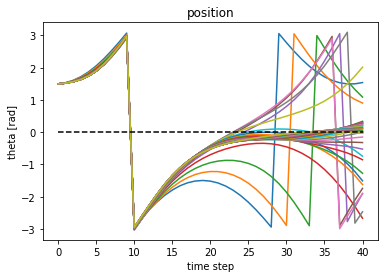

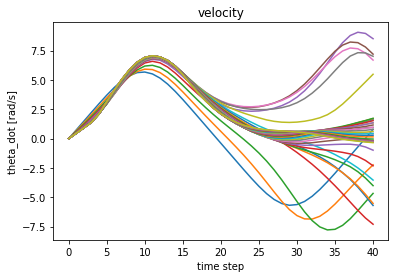

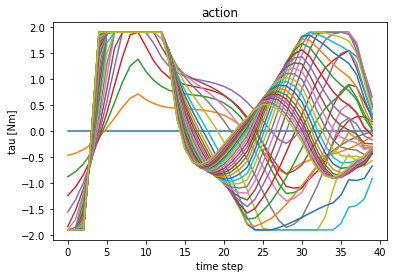

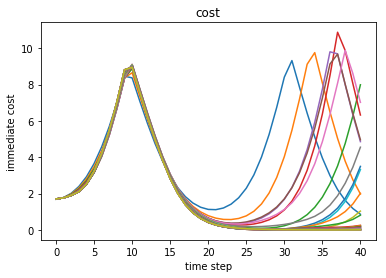

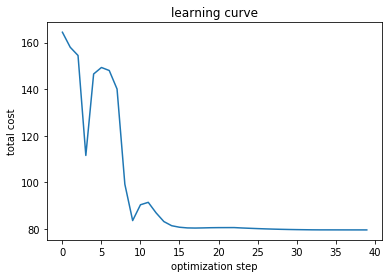

CPU times: user 1.76 s, sys: 1.1 s, total: 2.85 s
Wall time: 1.29 s


In [4]:
%%time
optimization_steps = 40

# sample hyperparameters
time_horizon = 40
alpha = 0.1
beta = 0.01
gamma = 0.3


# object instances
model = InvertedPendulum()
ilqg_solver = ILQGSolver(model, time_horizon, alpha, beta, gamma)


# optimization...
# ...init arrays to save history
s = np.zeros((optimization_steps+1, time_horizon+1, ilqg_solver.model.dim_s))
a = np.zeros((optimization_steps+1, time_horizon, ilqg_solver.model.dim_a))
r = np.zeros((optimization_steps, time_horizon+1))

# ...execute optimization steps one at a time to save full history
s[0], a[0] = ilqg_solver.reset()
for k in range(optimization_steps):
#     sys.stdout.write("\rprogress: %d%%" % ((k+1)/optimization_steps*100))
    s[k+1], a[k+1] = ilqg_solver.optimize(1)
    r[k] = ilqg_solver.r.copy()


# plots
s0_fig = plt.figure()
s0_plot = s0_fig.add_subplot(111)
s1_fig = plt.figure()
s1_plot = s1_fig.add_subplot(111)
a_fig = plt.figure()
a_plot = a_fig.add_subplot(111)
r_fig = plt.figure()
r_plot = r_fig.add_subplot(111)
ret_fig = plt.figure()
ret_plt = ret_fig.add_subplot(111)

for i in range(1,optimization_steps):
    s0_plot.plot(s[i, :, 0])
    s1_plot.plot(s[i, :, 1])
    a_plot.plot(a[i, :, 0])
    r_plot.plot(r[i, :])
ret_plt.plot(np.sum(r, axis=1))
s0_plot.plot(ilqg_solver.model.s_des[0] * np.ones(ilqg_solver.T + 1), color='black', linestyle='--')


s0_plot.set_title('position')
s0_plot.set_ylabel('theta [rad]')
s0_plot.set_xlabel('time step')
s1_plot.set_title('velocity')
s1_plot.set_ylabel('theta_dot [rad/s]')
s1_plot.set_xlabel('time step')
a_plot.set_title('action')
a_plot.set_ylabel('tau [Nm]')
a_plot.set_xlabel('time step')
r_plot.set_title('cost')
r_plot.set_ylabel('immediate cost')
r_plot.set_xlabel('time step')
ret_plt.set_title('learning curve')
ret_plt.set_ylabel('total cost')
ret_plt.set_xlabel('optimization step')

plt.show()

## Example 2: Model Predictive Control

In [5]:
class MPCController:
    """
    A basic MPC controller using the iLQG for trajectory optimization.
    """
    def __init__(self, ilqg_solver):
        self.ilqg_solver = ilqg_solver
        
    
    def get_action(self, s, a=None):
        """
        Performs iLQG trajectry optimization and returns the first control input. 
        Warm starts for t>0 by default.
        
        param s:     current system state
        param a:     list of control inputs to warm start the optimization
        return a:    next action to apply to the system
        """
        if a is None:
             # default warm start is last series of control inputs shifted by one time step
            a = np.concatenate((self.ilqg_solver.a[1:], [self.ilqg_solver.a[-1]]))
        else:
            a = a.reshape(np.shape(self.ilqg_solver.a))
        
        # reset ILQGSolver to the new starting position
        ilqg_solver.reset(s=s, a=a) 
        
        # perform iLQG updates until convergence
        s, a = ilqg_solver.optimize(1)
        J_old = np.sum(ilqg_solver.r)
        while True:
            s, a = ilqg_solver.optimize(1)
#             plt.plot(s[:,0])
#             plt.show()
            J_new = np.sum(ilqg_solver.r)
            if abs((J_new-J_old) / J_old) < 0.05:
#                 print('new time step')
                break
            else:
                J_old = J_new
        return a[0]

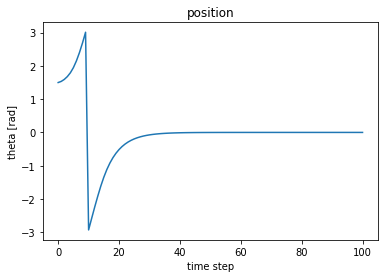

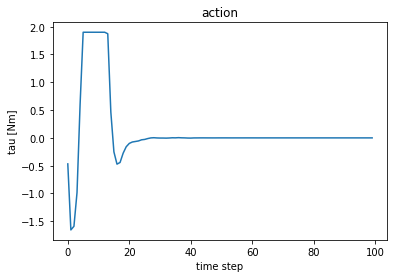

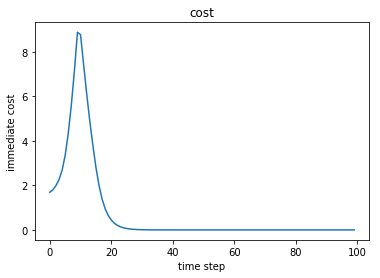

CPU times: user 4.89 s, sys: 705 ms, total: 5.6 s
Wall time: 4.57 s


In [6]:
%%time
# MPC Example
time_steps = 100


# sample hyperparameters
time_horizon = 40
alpha = 0.1
beta = 0.01
gamma = 0.3


# object instances
model = InvertedPendulum()
ilqg_solver = ILQGSolver(model, time_horizon, alpha, beta, gamma)
mpc_controller = MPCController(ilqg_solver)


# run mpc controller
s = np.zeros((time_steps+1, model.dim_s))
a = np.zeros((time_steps, model.dim_a))
r = np.zeros((time_steps))
s[0] = model.s0
for t in range(time_steps):
    a[t] = mpc_controller.get_action(s[t])
    r[t] = mpc_controller.ilqg_solver.r[0]
    s[t+1] = model.f(s[t], a[t])


# plots
s_fig = plt.figure()
s_plt = s_fig.add_subplot(111)
s_plt.plot(s[:,0]);
s_plt.set_title('position')
s_plt.set_ylabel('theta [rad]')
s_plt.set_xlabel('time step')


a_fig = plt.figure()
a_plt = a_fig.add_subplot(111)
a_plt.plot(a[:,0]);
a_plt.set_title('action')
a_plt.set_ylabel('tau [Nm]')
a_plt.set_xlabel('time step')

r_fig = plt.figure()
r_plt = r_fig.add_subplot(111)
r_plt.plot(r)
r_plt.set_title('cost')
r_plt.set_ylabel('immediate cost')
r_plt.set_xlabel('time step')

plt.show()